Genetski algoritam je primer p metaheuristike, kod kojih imamo populaciju rešenja za razliku od s metaheuristika, gde smo imali samo jedno rešenje.
Genetski algoritam je osmišljen po ugledu na biološku evoluciju.
Sada evoluiramo rešenja nekog optimizacionog problema.
Svaka jedinka predstavlja jedno rešenje i ima svoj kod, paralela bi bila npr. DNK, kao i funkciju prilagođenosti (fitness).
I ovde je ideja da najprilagođenije jedinke opstaju.
Formiramo populaciju jedinki koje evoluiramo kroz određeni broj generacija, odnosno iteracija.
Postoje i druge opcije, ali ovde smo se odlučili da u novoj generaciji formiramo novu populaciju i da ona zameni postojeću.
Tri glavne komponente genetskog algoritma su:
1. selekcija - odabir jedinki za ukrštanje na osnovu njihove prilagođenosti. Dve osnovne varijante selekcije su:
    - turnirska - odabir k slučajnih jedinki iz populacije i "turnirsko takmičenje" gde pobeđuje najprilagođenija od izabranih jedniki.
    Razmisliti šta se dešava kada je k = 1, a šta kada je k = veličini populacije.
    - ruletska - raspoređivanje svih jedinki na pristrasan ruletski točak gde je veličina isečka koji jedinka zauzima proporcionalna njenom fitnesu. Dakle, bolje prilagođene jedinke imaju veću verovatnoću da budu izabrane.
    Razmisliti o situaciji gde je npr. jedna jedinka ubedljivo bolja od ostalih. Kako biste rešili ovakav problem?
2. ukrštanje - formiranje novih jedinki na osnovu postojećih - u ovom slučaju formiramo dva potomka od dva roditelja. Nekoliko osnovnih varijanti ukrštanja su:
    - jednopoziciono ukrštanje - odabir jedne slučajne tačke prekida u kodu roditeljskih jedinki i unakrsno ukrštanje kodova
    - višepoziciono ukrštanje - analogno
    - uniformno ukrštanje - za svaki "gen", u ovom slučaju bit u rešenju, bacamo novčić i na osnovu toga biramo iz kog roditelja ćemo kopirati trenutni "gen" u dete
3. mutacija - sa određenom (malom) verovatnoćom na slučajan način unosimo promenu u gene deteta - u ovom slučaju negiramo bit

In [8]:
import random


class Individual:
    """
    Individual of genetic algorithm
    code - represents one solution
    fitness - quality of the solution
    """
    def __init__(self, facility_cost, user_facility_cost):
        self.code = [random.random() < 0.5 for _ in range(len(facility_cost))]
        self.facility_cost = facility_cost
        self.user_facility_cost = user_facility_cost
        self.calc_fitness()

    def calc_fitness(self):
        """UFLP cost - negative because we want to minimize cost, but maximize fitness"""
        if not any(self.code):
            self.fitness = -float('inf')
        built_schools = sum(x for i, x in enumerate(self.facility_cost) if self.code[i])
        user_to_nearest_school = sum(min(cost for i, cost in enumerate(user) if self.code[i]) for user in self.user_facility_cost)
        self.fitness = -(built_schools + user_to_nearest_school)

In [9]:
def selection(population: list[Individual], k: int):
    """
    Tournament selection
    1. Choose random k individuals from the population
    2. The best of those k wins the tournament and is selected for crossover

    TODO: roulette (rang) selection
    """
    # return random.choices(population, weights=[p.fitness for p in population])[0]
    k = min(len(population), k)
    participants = random.sample(population, k)
    return max(participants, key=lambda x: x.fitness)

In [10]:
def crossover(parent1, parent2, child1, child2):
    """
    Single point crossover - changes children in place
    
    TODO:
    1. n-point crossover - self-explanatory
    2. uniform - for each bit flip a coin
    """
    breakpoint = random.randrange(1, len(parent1.code))
    child1.code[:breakpoint] = parent1.code[:breakpoint]
    child1.code[breakpoint:] = parent2.code[breakpoint:]

    child2.code[:breakpoint] = parent2.code[:breakpoint]
    child2.code[breakpoint:] = parent1.code[breakpoint:]

In [11]:
def mutation(child: Individual, p: float):
    """
    With probability p flip each bit
    """
    # child.code = [not x if random.random() < p else x for x in child.code]
    for i in range(len(child.code)):
        if random.random() < p:
            child.code[i] = not child.code[i]

In [12]:
import numpy as np
noise = np.random.normal(0, 0.01, size=2)
noise

array([0.00314962, 0.01216343])

In [13]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np


def ga(facility_cost, user_facility_cost, population_size, num_generations, tournament_size, mutation_prob, elitism_size):
    """
    Genetic Algorithm for UFLP
    
    population_size - number of individuals in a generation
    num_generations - number of iterations of algorithm
    elitism_size - number of best individuals that will be copied to next generation
                 - to avoid losing them due to unlucky crossovers and mutations
    """
    assert population_size >= 2
    population = [Individual(facility_cost, user_facility_cost) for _ in range(population_size)]
    new_population = [Individual(facility_cost, user_facility_cost) for _ in range(population_size)]

    # parity of elitism_size and population_size must be the same
    # since we are going two by two in the inner loop
    if elitism_size % 2 != population_size % 2:
        elitism_size += 1

    best_fitnesses = []
    for it in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        best_fitnesses.append(population[0].fitness)
        # print(population[0].fitness)
        new_population[:elitism_size] = population[:elitism_size]
        for i in range(elitism_size, population_size, 2):
            # we should fill new_pop[i] and new_pop[i+1]
            parent1 = selection(population, tournament_size)
            # HACK: to avoid choosing parent1 again, we temporarily set its fitness to inf
            # what if tournament_size is 1?
            tmp, parent1.fitness = parent1.fitness, float('-inf')
            parent2 = selection(population, tournament_size)
            # revert change
            parent1.fitness = tmp

            # option 2 - probabilistic
            # TODO: calculate the probability based on tournament_size
            # what if tournament_size == population_size?
            # parent2 = parent1
            # while parent1 == parent2:
            #     parent2 = selection(population, tournament_size)
            
            crossover(parent1, parent2, new_population[i], new_population[i+1])

            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)

            new_population[i].calc_fitness()
            new_population[i+1].calc_fitness()
        
        population = deepcopy(new_population)

    best_individual = max(population, key=lambda x: x.fitness)
    print(f'best fitness: {best_individual.fitness}, best code: {best_individual.code}')
    print(np.unique(best_fitnesses))
    plt.plot(best_fitnesses)

In [14]:
x = 2
x, tmp = 3, x
x, tmp

(3, 2)

In [15]:
def read_line_of_ints(f):
    return [int(x) for x in f.readline().split()]

In [16]:
def read_instance(file_path: str):
    with open(file_path, 'r') as f:
        m, n = read_line_of_ints(f)
        cost = [read_line_of_ints(f) for _ in range(m)]
        facility_cost = read_line_of_ints(f)
        return cost, facility_cost

In [17]:
import numpy as np

def read_bk_instance(file_path: str = 'BildeKrarup/B/B1.1'):
    with open(file_path, 'r') as f:
        f.readline()
        num_resources, num_users, _ = read_line_of_ints(f)
        cost = [[None for _ in range(num_users)] for _ in range(num_resources)]
        facility_cost = [None for _ in range(num_resources)]
        for i in range(num_resources):
            ints = read_line_of_ints(f)
            cost[i] = ints[2:]
            facility_cost[i] = ints[1]
    return np.array(cost).transpose(), facility_cost

In [18]:
# cost, facility_cost = read_instance('..\\Downloads\\uflp1.txt')
cost, facility_cost = read_bk_instance('..\\Downloads\\B1.1')

best fitness: -23468, best code: [False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False]
[-91558 -75483 -68638 -58023 -52806 -39649 -39494 -38220 -30075 -26922
 -26278 -24183 -23919 -23897 -23468]


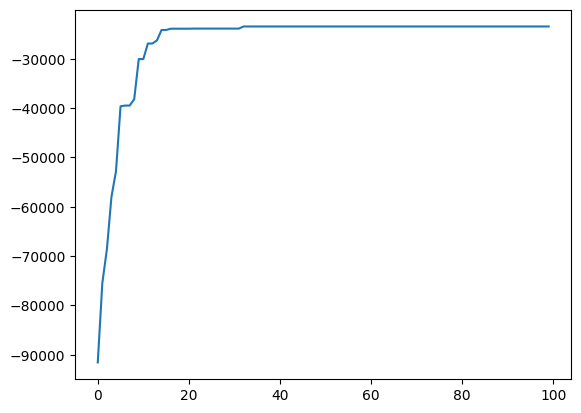

In [19]:
ga(facility_cost=facility_cost,
   user_facility_cost=cost,
   population_size=100,
   num_generations=100,
   tournament_size=10,
   mutation_prob=0.05,
   elitism_size=10,
)